In [1]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from scipy import special
from ipywidgets import interact
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


py.offline.init_notebook_mode(connected=True)


devices_info = pd.read_csv('C:\\Users\\ruben\\Desktop\\Investigation\\updated_dataset_07_3_2018\\devices.csv', index_col='id', skipinitialspace=True, parse_dates=['created_at', 'updated_at'])

devices_info['model'] = devices_info['model'].str.lower()
devices_info['manufacturer'] = devices_info['manufacturer'].str.lower()
devices_info['brand'] = devices_info['brand'].str.lower()
devices_info['product'] = devices_info['product'].str.lower()

print('loaded')

loaded


In [2]:
all_versions_percentage = devices_info.os_version.value_counts(normalize=True) #get all version percentage

layout = go.Layout(
    title='Android Version Percentages',
    yaxis=dict(
        title='Percentage'
    ),
    xaxis=dict(
        title='Android Version'
    )
)

data = go.Bar(
            x = all_versions_percentage.index,
            y = all_versions_percentage.values
    )

fig = go.Figure(data = [data], layout=layout)
py.offline.plot(fig)

'file://C:\\Users\\ruben\\Dropbox\\Jupyter Stuff\\temp-plot.html'

In [3]:
def getVersionCounter(all_versions_counts):
    version_counts = dict()
    
    for index_val, series_val in all_versions_counts.iteritems():
        if index_val[0] in version_counts:
            version_counts[index_val[0]] += series_val
        else:
            version_counts[index_val[0]] = series_val
    
    return version_counts

version_percentage = getVersionCounter(all_versions_percentage) #join all versions

keys, values = zip(*version_percentage.items()) #gets 2 lists one with keys another with values od dictionary
values = [x * 100 for x in values] #convert to percentage (int)

layout2 = go.Layout(
    title='Devices Android Version',
    yaxis=dict(
        title='Percentage'
    ),
    xaxis=dict(
        title='Version'
    )
)

data2 = go.Bar(
            x = keys,
            y = values
    )



fig = go.Figure(data = [data2], layout=layout2)
py.offline.plot(fig)



'file://C:\\Users\\ruben\\Dropbox\\Jupyter Stuff\\temp-plot.html'

In [4]:
devices_data = pd.read_csv('C:\\Users\\ruben\\Desktop\\Investigation\\updated_dataset_07_3_2018\\devices.csv', index_col='id', parse_dates=['created_at', 'updated_at'])
samples_data = pd.read_csv('C:\\Users\\ruben\\Desktop\\Investigation\\updated_dataset_07_3_2018\\samples.csv', usecols=['device_id', 'timestamp', 'battery_state', 'battery_level'], parse_dates=['timestamp'])


In [5]:
from plotly.widgets import GraphWidget
from ipywidgets.embed import embed_minimal_html



# computes a list of [discharging rate per hour (percentage), time to discharge 1% (seconds)] of given discharging sample, ex: [0.41, 356]
def computeDischargeKPI(valid_sample):
    previous_state_index = 0
    battery_per_hour = []
    discharge_per_unit = 0
    
    for index, row in valid_sample.iterrows():
        if index != 0:
            discharge_per_unit += (row['timestamp'] - valid_sample['timestamp'].iloc[index - 1]).seconds
        
        if (row['timestamp'] - valid_sample['timestamp'].iloc[previous_state_index]).seconds >= 3600:
            battery_per_hour.append(abs(row['battery_level'] - valid_sample['battery_level'].iloc[previous_state_index]))
            previous_state_index = index

    if not battery_per_hour:
        return []
    
    return [sum(battery_per_hour) / float(len(battery_per_hour)), discharge_per_unit/len(valid_sample.index)]


#time to charge 1% (seconds) of given charging sample
def computeChargeKPI(valid_sample):
    previous_state_index = 0
    charge_per_unit = 0
    
    for index, row in valid_sample.iterrows():
        if index != 0:
            charge_per_unit += (row['timestamp'] - valid_sample['timestamp'].iloc[index - 1]).seconds
    return charge_per_unit/len(valid_sample.index)


#check if is charge/discharge >= given percentage and if they the step checks (step=0, continuous sample)
def checkSampleIsValid(subset, percentage, step):
    return abs(subset['battery_level'].iloc[len(subset) - 1] - subset['battery_level'].iloc[0]) >= percentage and (len(subset) - 1 == abs(subset['battery_level'].iloc[len(subset) - 1] - subset['battery_level'].iloc[0]) * 100)


def computeDeviceKPI(devID, percentage, step):
    device_samples = samples_data.loc[samples_data.device_id == devID].drop_duplicates(subset=['timestamp']).sort_values(by='timestamp').reset_index(drop=True)
    
    if device_samples.empty:
        return [-1, -1, -1, -1, -1]
    
    charge_to_full = 0
    charge_to_not_full = 0

    results_descharging = []
    results_charging = []
    
    previous_state_index = 0
    for index, row in device_samples.iterrows():
        #check diference on battery state to divide the samples into subsets
        if row['battery_state'] != device_samples['battery_state'].iloc[previous_state_index]:
            #creates substet only with charging samples ending in full state 
            if row['battery_state'] == 'Full':
                subset = device_samples.loc[previous_state_index:index].drop_duplicates(subset=['battery_level'], keep='last').reset_index(drop=True)
                
                #check if samples are valid and discard not charging samples
                if 'Not charging' not in subset['battery_state'].unique() and checkSampleIsValid(subset, percentage, step):
                    charge_to_full += 1
                    results_charging.append(computeChargeKPI(subset))
        
                previous_state_index = index + 1

            #create all others subsets (discharging, not charging samples, only charging, only full)
            else:
                subset = device_samples[previous_state_index:index].drop_duplicates(subset=['battery_level']).reset_index(drop=True)
                
                if subset['battery_state'].iloc[0] == 'Charging':
                    charge_to_not_full += 1
                    
                #check if samples are valid and discard not charging samples
                if 'Not charging' not in subset['battery_state'].unique() and checkSampleIsValid(subset, percentage, step):
                     if subset['battery_state'].iloc[0] == 'Discharging':
                        res = computeDischargeKPI(subset)
                        if len(res) != 0:
                            results_descharging.append(res)
                        else:
                            results_charging.append(computeChargeKPI(subset))
                        
                previous_state_index = index
                
        #check if is the last sample to compute the last substet
        if index == len(device_samples) - 1:
            subset = device_samples.loc[previous_state_index:index].drop_duplicates(subset=['battery_level'], keep='last').reset_index(drop=True)
                
            #check if samples are valid and discard not charging samples
            if not subset.empty and 'Not charging' not in subset['battery_state'].unique() and checkSampleIsValid(subset, percentage, step):
                if subset['battery_state'].iloc[0] == 'Discharging':
                    res = computeDischargeKPI(subset)
                    if len(res) != 0:
                        results_descharging.append(res)
                    else:
                        results_charging.append(computeChargeKPI(subset))

    if len(results_charging) != 0 and len(results_descharging) != 0:
        return [time.strftime("%M:%S", time.gmtime(sum(results_charging) / float(len(results_charging)))), time.strftime("%M:%S", time.gmtime(sum([row[1] for row in results_descharging])/len(results_descharging))), sum([row[0] for row in results_descharging])/len(results_descharging) , charge_to_full, charge_to_not_full]  # adding a row
    elif len(results_charging) != 0:
        return [time.strftime("%M:%S", time.gmtime(sum(results_charging) / float(len(results_charging)))), -1, -1, charge_to_full, charge_to_not_full]  # adding a row
    elif len(results_descharging) != 0:
        return [-1, time.strftime("%M:%S", time.gmtime(sum([row[1] for row in results_descharging])/len(results_descharging))), sum([row[0] for row in results_descharging])/len(results_descharging) , charge_to_full, charge_to_not_full]  # adding a row
    else:
        return [-1, -1, -1, -1, -1]  # adding a row

#-----------------------------------------------------------------------------------------------


kpis_res = computeDeviceKPI(1, 0.5, 0)

kpis_res[2] = round(kpis_res[2]*100)


@interact(drop_options = widgets.Dropdown(options=[str(i) for i in list(devices_data.index)], value='1', description='Device ID:', disabled=False,))
def update_plot(drop_options):
    data = []
    
    for s in drop_options:
        trace = go.Table(
            header=dict(values=['Device KPI', 'Value'],
                        line = dict(color='#7D7F80'),
                        fill = dict(color='#a1c3d1'),
                        align = ['left'] * 5),
            cells=dict(values=[['Average time to charge 1%', 'Average time to discharge 1%', 'Average discharge rate per hour', 'Reached full state', 'Charging does not reached full state'],
                       computeDeviceKPI(int(s), 0.5, 0)],
                       line = dict(color='#7D7F80'),
                       fill = dict(color='#EDFAFF'),
                       align = ['left'] * 5))

    layout = dict(width=650, height=350)
    data = [trace]
    fig = dict(data=data, layout=layout)
    py.offline.iplot(fig)
    


<IPython.core.display.Javascript object>

A Jupyter Widget

In [6]:
layout = go.Layout(
    title='Installation Stats',
    yaxis=dict(
        title='Number of Devices'
    ),
    xaxis=dict(
        title='Date'
    )
)

data = go.Scatter(
    x = list(devices_info['created_at']),
    y = list(devices_info.index)
)

fig = go.Figure(data = [data], layout=layout)
py.offline.plot(fig)

'file://C:\\Users\\ruben\\Dropbox\\Jupyter Stuff\\temp-plot.html'

In [7]:
samplesdata = pd.read_csv('C:\\Users\\ruben\\Desktop\\Investigation\\updated_dataset_07_3_2018\\samples.csv', usecols=['device_id', 'timestamp', 'memory_active', 'battery_level', 'temperature', 'usage'], parse_dates=['timestamp'])

samplesdata.head()


,device_id,timestamp,battery_level,memory_active,temperature,usage
0,1,2017-10-08 12:50:04,0.82,496480,28.5,0.03
1,1,2017-10-08 12:50:04,0.82,496480,28.5,0.03
2,1,2017-10-08 12:55:15,0.81,500276,29.0,0.03
3,1,2017-10-08 12:58:28,0.80,466868,29.9,0.03
4,1,2017-10-08 13:03:16,0.79,507264,29.2,0.03


In [8]:
device_samples = samplesdata[samplesdata['device_id'] == 1]

l = []
for index, row in device_samples.iterrows():
    l.append(row['battery_level'] * 100)

device_samples = device_samples.assign(battery = pd.Series(l, index=device_samples.index))
device_samples.drop('battery_level', axis=1, inplace=True)

device_samples = device_samples.drop_duplicates(subset=['timestamp']).sort_values(by='timestamp').reset_index(drop=True)

device_samples.head()

,device_id,timestamp,memory_active,temperature,usage,battery
0,1,2017-10-08 12:50:04,496480,28.5,0.03,82.0
1,1,2017-10-08 12:55:15,500276,29.0,0.03,81.0
2,1,2017-10-08 12:58:28,466868,29.9,0.03,80.0
3,1,2017-10-08 13:03:16,507264,29.2,0.03,79.0
4,1,2017-10-08 13:14:22,490652,27.3,0.03,80.0


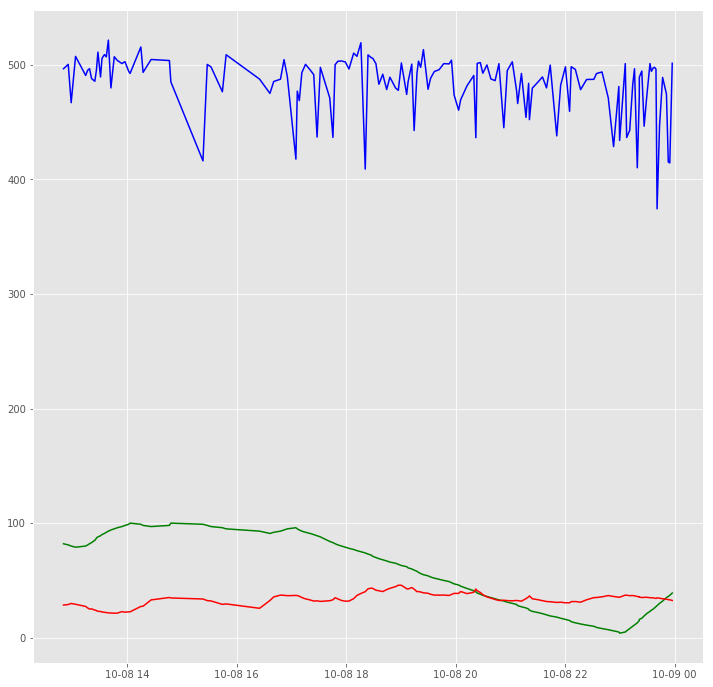

In [9]:
test = device_samples[(device_samples['timestamp'] > '2017-10-8') & (device_samples['timestamp'] < '2017-10-9')]

# test.tail()
width = 12
height = 12
plt.figure(figsize=(width, height))

plt.plot(list(test['timestamp']), list(test['battery']), 'g')
plt.plot(list(test['timestamp']), list(test['temperature']), 'r')
plt.plot(list(test['timestamp']), list(test['memory_active'] / 1000), 'b')

In [10]:
dates = []

for i in list(device_samples['timestamp']):
    dates.append(i.date())


option_list = list(set(dates))

option = []
for i in option_list:
    option.append(i.strftime('%Y-%m-%d'))

    
@interact(drop_options = widgets.Dropdown(options=option, value=option[3], description='Date:', disabled=False,))
def update_plot(drop_options):
    s = drop_options
    next_day = re.sub(s[len(s) - 1] + '$', str(int(s[len(s) - 1]) + 1), s)

    test = device_samples[(device_samples['timestamp'] > s) & (device_samples['timestamp'] < next_day)]

    layout = go.Layout(
        title='Device Battery Level VS Temperature',
        xaxis=dict(
            title='Time',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title='Value',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
    
    trace1 = go.Scatter(
        x = list(test['timestamp']),
        y = list(test['battery']),
        mode = 'lines+markers',
        name = 'Battery Level'
    )

    trace2 = go.Scatter(
        x = list(test['timestamp']),
        y = list(test['temperature']),
        mode = 'lines+markers',
        name = 'Temperature'
    )
    
    

    data = [trace1, trace2]
    
    fig = go.Figure(data=data, layout=layout)
    py.offline.plot(fig, filename='styling-names')
    
#     py.offline.iplot(data)
    

A Jupyter Widget

In [11]:
import re



s

NameError: name 's' is not defined